<a href="https://colab.research.google.com/github/Tahimi/numericalMethods/blob/main/bvp_FEMLinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Finite Element Method For Linear Second Order Differential Equations

In [ ]:
# Nonlinear BVP of second order
# EDO: y'' = f(t, y, y'), tL <= t <= tR
# BCs: y(tL) = yL and y(tR) = yR

# Exemple Problem
# EDO: y'' = -9.8, 0 <= t <= 5
# BCs: y(0) = 0 and y(5) = 50

import numpy as np

f = lambda t, y: -9.8

# initial (left) and final (right) instants of time
tL = 0
tR = 5

# left and right altitudes (Dirichlet BCs)
yL0 = 0
yR0 = 50

N = 5
h = (tR - tL)/N
print('h = ', h)

t = np.linspace(tL, tR, N+1)
print('t = ', t)

y = np.zeros((2, N+1)) # y = [altitude, velocidade]
y[0][ 0] = yL0
y[0][-1] = yR0

print('y = \n', y)

h =  1.0
t =  [0. 1. 2. 3. 4. 5.]
y = 
 [[ 0.  0.  0.  0.  0. 50.]
 [ 0.  0.  0.  0.  0.  0.]]


In [ ]:
class Grid:
  def __init__(self, t):
    self.t = t
    self.cellsNbr = len(self.t) - 1
    self.nodes = [Node(i, ti) for i, ti in enumerate(self.t)]
    self.cells = [Cell(i, [self.nodes[i], self.nodes[i+1]]) for i in range(self.cellsNbr)]

class Node:
  def __init__(self, idx, t):
    self.idx = idx
    self.t = t

class Cell:
  def __init__(self, idx, nodes):
    self.idx = idx
    self.nodes = nodes
    self.faces = [Face(0, self.nodes[0]), Face(1, self.nodes[-1])]

class Face:
  def __init__(self, idx, node, isNeumann = False):
    self.idx = idx
    self.node = node
    self.isNeumann = isNeumann
    self.dS = np.array([1]) * (-1 if self.idx == 0 else 1)

In [ ]:
# making the grid
grid = Grid(t)

In [ ]:
from sympy import symbols, Matrix, lambdify, diff, integrate
from IPython.display import display

t_, y_ = symbols('t_ y_')

# Trial functions
phi = lambda t: Matrix([1-t/h, t/h])
Dphi = lambda t: Matrix(phi(t_).diff(t_))
display('phi = ', phi(t_))
display('Dphi = ', Dphi(t_))

# Test functions
psi = phi
Dpsi = Dphi

'phi = '

Matrix([
[1 - 1.0*t_],
[    1.0*t_]])

'Dphi = '

Matrix([
[-1.0],
[ 1.0]])

In [ ]:
# computing the Finite Element's Stiffness Matrix, Ke
Ke = np.zeros((2,2))
for i in range(len(Dphi(t_))):
  for j in range(len(Dpsi(t_))):
    Ke[i, j] = integrate(Dphi(t_)[i] * Dpsi(t_)[j], (t_, 0, h)).doit()
print("Finite Element's Stiffness Matrix: Ke = \n", Ke)

Finite Element's Stiffness Matrix: Ke = 
 [[ 1. -1.]
 [-1.  1.]]


In [ ]:
# computing the Grid's Stiffness Matrix, K
gridNodesNbr = len(grid.nodes)
K = np.zeros((gridNodesNbr, gridNodesNbr))
for cell in grid.cells:
  cellNodesIdx = [node.idx for node in cell.nodes]
  cellIdxsInK = np.ix_(cellNodesIdx, cellNodesIdx)
  K[cellIdxsInK] += Ke
print("Grid's Stifness Matrix: K = \n", K)

how_to_use = '''
np.ix_() to select a submatrix of K,
np.ix_([0,0],[0,1]) = ([[0],[1]], [[0,1]]) = (lines, columns)
--> K[([[0],[1]], [[0,1]])] = K entries in lines 0 and 1 and columns 0 and 1
                            = [[K00, K01]
                               [K10, K11]]
                            = submatrix of K
'''

Grid's Stifness Matrix: K = 
 [[ 1. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  1.]]


In [ ]:
# computing the Finite Element's Source Vector, Fe
Fe = np.zeros((2,))
for i in [0, 1]:
  Fe[i] = integrate(-f(t_,y_)*phi(t_)[i], (t_, 0, h)).doit()
print("Finite Element's Source Vector: Fe = ", Fe)

Finite Element's Source Vector: Fe =  [4.9 4.9]


In [ ]:
# computing the Grid's Source Vector, F
F = np.zeros((N + 1,))
for cell in grid.cells:
  cellNodesIdx = [node.idx for node in cell.nodes]
  F[cellNodesIdx] += Fe
print("Grid's Source Vector: F = \n", F)

Grid's Source Vector: F = 
 [4.9 9.8 9.8 9.8 9.8 4.9]


In [ ]:
# Applying the Dirichlet BCs
K[ 0, :] = 0; K[ 0, 0] = 1; F[ 0] = yL0
K[-1, :] = 0; K[-1,-1] = 1; F[-1] = yR0
print("Grid's Stifness Matrix: K = \n", K)
print("Grid's Source Vector: F = \n", F)

Grid's Stifness Matrix: K = 
 [[ 1.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  1.]]
Grid's Source Vector: F = 
 [ 0.   9.8  9.8  9.8  9.8 50. ]


In [ ]:
# computing the Grid's Neumann Boundary Vector, F
G = np.zeros((N + 1,))
for cell in grid.cells:
  for face in cell.faces:
    if face.isNeumann:
      nodeIdx = face.node.idx
      velocity = np.array([y[1][nodeIdx]])
      G[nodeIdx] += np.dot(velocity, face.dS)
print("Grid's Neumann Boundary Vector: G = ", G)

Grid's Neumann Boundary Vector: G =  [0. 0. 0. 0. 0. 0.]


In [ ]:
print('K = \n', K)
print('F = ', F)
print('G = ', G)
y[0] = np.linalg.solve(K, F+G)
print('altitude = y[0] = ', y[0])

K = 
 [[ 1.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  1.]]
F =  [ 0.   9.8  9.8  9.8  9.8 50. ]
G =  [0. 0. 0. 0. 0. 0.]
altitude = y[0] =  [ 0.  29.6 49.4 59.4 59.6 50. ]


In [ ]:
# computing the velocity profile, y[1] = ?
# intermediate points
for i in range(0,N):
  y[1][i] = (y[0][i+1] - y[0][i])/h # Forward Euler
y[1][-1] = (y[0][-1] - y[0][-2])/h # Backward Euler
print('velocity = y[1] = ', y[1])

yL1 = y[1][0]
yR1 = y[1][-1]
print('Initial velocity = yL1 = ', yL1)
print('Final velocity = yR1 = ', yR1)

velocity = y[1] =  [29.6 19.8 10.   0.2 -9.6 -9.6]
Initial velocity = yL1 =  29.6
Final velocity = yR1 =  -9.600000000000001


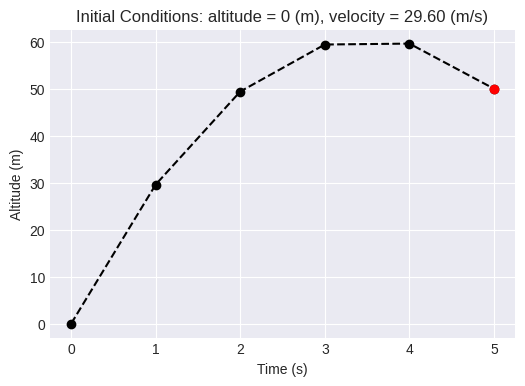

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

plt.figure(figsize = (6,4))
plt.plot(t, y[0], 'ko--')
plt.plot(tR, yR0, 'ro')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title(f'Initial Conditions: altitude = {yL0} (m), velocity = {yL1:.2f} (m/s)')
plt.show()